In [ ]:
# import os
# import sys
# import json
# import glob
# import pandas as pd
# import shutil

# # Add project root so that the functions can be imported
# sys.path.append(os.path.abspath('../..'))
# from utlis.sync_utlis.mini_dannce_sync import (
#     # sync_videos,
#     # align_miniscope_to_sixcam,
#     # load_aligneddannce_and_process_ca_data,
#     # load_aligneddannce_and_process_ca_data_custom,
#     run_mini_dannce_sync
# )

# def extract_mini_directory(raw_mini_path):
#     """
#     Normalize the mini_path for downstream processing.
#     If raw_mini_path ends with 'My_V4_Miniscope', remove that folder.
#     Otherwise, return the normalized path with a trailing slash.
#     """
#     norm_path = os.path.normpath(raw_mini_path)
#     if os.path.basename(norm_path) == "My_V4_Miniscope":
#         cleaned = os.path.dirname(norm_path)
#     else:
#         cleaned = norm_path
#     if not cleaned.endswith(os.sep):
#         cleaned += os.sep
#     return cleaned

# def extract_mini_directory_for_nc(raw_mini_path):
#     """
#     Normalize the mini_path for mapping lookup.
#     This version does NOT remove 'My_V4_Miniscope' and simply
#     returns the normalized path with a trailing slash.
#     """
#     norm_path = os.path.normpath(raw_mini_path)
#     if not norm_path.endswith(os.sep):
#         norm_path += os.sep
#     return norm_path

# def extract_rec_directory(raw_rec_path):
#     """
#     Given a full rec_path (including a filename), return only its parent directory, ensuring a trailing slash.
#     """
#     parent_dir = os.path.dirname(os.path.dirname(os.path.dirname(raw_rec_path)))
#     if not parent_dir.endswith(os.sep):
#         parent_dir += os.sep
#     return parent_dir

# def extract_name_suffix(nc_file_path):
#     """
#     Given a full path to an .nc file, extract a suffix from the filename.
#     For example, if the file is named:
#       minian_dataset_wnd1000_stp700_max15_diff3.5_pnrauto.nc
#     then return: wnd1000_stp700_max15_diff3.5_pnrauto
#     If the filename does not follow the expected pattern, return an empty string.
#     """
#     nc_basename = os.path.basename(nc_file_path)
#     prefix = "minian_dataset_"
#     suffix = ".nc"
#     if nc_basename.startswith(prefix) and nc_basename.endswith(suffix):
#         return nc_basename[len(prefix):-len(suffix)]
#     return ""

# def get_rec_path_for_mini(raw_mini_path, mapping):
#     """
#     Given the raw mini_path and a mapping dictionary, return its corresponding rec_path.
#     """
#     if raw_mini_path not in mapping:
#         raise KeyError(f"Key '{raw_mini_path}' not found in mapping.")
#     return mapping[raw_mini_path].get("rec_path")

# def mirror_MIR_Aligned(rec_path, mini_path):
#     src = os.path.join(rec_path, "MIR_Aligned")
#     dst = os.path.join(mini_path, "MIR_Aligned")
#     print(f"DEBUG: src exists? {os.path.isdir(src)} → {src}")
#     if not os.path.isdir(src):
#         print(f"[mirror] no MIR_Aligned at {src}")
#         return
#     os.makedirs(dst, exist_ok=True)
#     shutil.copytree(src, dst, dirs_exist_ok=True)
#     print(f"[mirror] copied MIR_Aligned → {dst}")


# def process_good_minis(csv_path, json_path, nc_csv_path, dry_run=True, only_com=False):
#     """
#     Process all minis whose 'condition' is 'good' or 'good_vein', 
#     look up their rec_path, find the right .nc file, and run alignment.
#     Falls back to 'minian_dataset.nc' if no suffix/key is available.
#     """
#     # 1) load and filter
#     df = pd.read_csv(csv_path)
#     df_filtered = df[df['condition'].isin(["good", "good_vein"])]
#     with open(json_path, 'r') as f:
#         mini_to_rec = json.load(f)

#     for _, row in df_filtered.iterrows():
#         raw_mini_path = row["rec_path"]
#         try:
#             raw_rec_path = mini_to_rec[raw_mini_path]["rec_path"]
#         except KeyError:
#             print(f"Key '{raw_mini_path}' not found in mapping.")
#             continue

#         if not raw_rec_path:
#             print(f"No rec_path for {raw_mini_path}")
#             continue

#         # normalize paths
#         mini_path    = extract_mini_directory(raw_mini_path)
#         mapping_key  = extract_mini_directory_for_nc(raw_mini_path)
#         rec_path     = extract_rec_directory(raw_rec_path)

#         print(f"\nUsing rec_path: {rec_path}  for mini_path: {mini_path}")

#         # define output markers
#         dannce_file = os.path.join(rec_path, "DANNCE", "predict00", "save_data_AVG.mat")
#         mir_base    = os.path.join(rec_path, "MIR_Aligned")

#         # gather all .nc files in the miniscope folder
#         nc_folder = raw_mini_path
#         nc_files  = glob.glob(os.path.join(nc_folder, "*.nc"))
#         selected_nc_file = None

#         # ---- single-file case ----
#         if len(nc_files) == 1:
#             basename = os.path.basename(nc_files[0])
#             if basename.startswith("minian_dataset_") and basename.endswith(".nc"):
#                 keyyy = basename[len("minian_dataset_"):-3]
#                 selected_nc_file = nc_files[0]
#                 print(f"key: {keyyy}")
#             else:
#                 keyyy = ""
#                 selected_nc_file = os.path.join(nc_folder, "minian_dataset.nc")
#                 print("using default mini.nc")

#             print(f"Selected .nc file: {selected_nc_file} (key='{keyyy}')")

#             # ---- single-file case ----
#             # after your keyyy logic…
#             mir_base = os.path.join(rec_path, "MIR_Aligned")

#             if os.path.isdir(mir_base):
#                 h5_files = [
#                     fn for fn in os.listdir(mir_base)
#                     if fn.endswith(".h5") and "aligned_predictions_with_ca_and_dF_F" in fn
#                 ]
#             else:
#                 h5_files = []

#             if only_com:
#                 mir_done = bool(h5_files)
#             else:
#                 mir_done = any(not fn.startswith("only_com_") for fn in h5_files)

#             if mir_done:
#                 print("Alignment already done; skipping.")
#                 continue

#             if not dry_run:
#                 run_mini_dannce_sync(rec_path, mini_path, keyyy or None, only_com)
#                 mirror_MIR_Aligned(rec_path, mini_path)





#         # ---- multiple-file case ----
#         else:
#             if os.path.exists(nc_csv_path):
#                 nc_map_df = pd.read_csv(nc_csv_path)
#                 for _, map_row in nc_map_df.iterrows():
#                     map_rec = extract_mini_directory_for_nc(map_row["rec_path"])
#                     if map_rec in mapping_key or mapping_key in map_rec:
#                         key = map_row["nc_file"]
#                         print(f"key of nc: {key}")
#                         candidate = os.path.join(nc_folder, f"minian_dataset_{key}.nc")
#                         if os.path.isfile(candidate):
#                             selected_nc_file = candidate
#                             print(f"Selected from mapping: {selected_nc_file}")

#                                            # inside your for‐map_row loop, once you’ve selected `candidate` and `key`

#                             # — universal skip logic —
#                             # inside your for-map_row loop, after you set `key` and `candidate`
#                             mir_base = os.path.join(rec_path, "MIR_Aligned")

#                             if os.path.isdir(mir_base):
#                                 h5_files = [
#                                     fn for fn in os.listdir(mir_base)
#                                     if fn.endswith(".h5") and "aligned_predictions_with_ca_and_dF_F" in fn
#                                 ]
#                             else:
#                                 h5_files = []

#                             if only_com:
#                                 mir_done = bool(h5_files)
#                             else:
#                                 mir_done = any(not fn.startswith("only_com_") for fn in h5_files)

#                             if mir_done:
#                                 print(f"[skip] already aligned for key={key}; skipping.")
#                                 break

#                             if not dry_run:
#                                 run_mini_dannce_sync(rec_path, mini_path, key, only_com)
#                                 mirror_MIR_Aligned(rec_path, mini_path)
#                             break



#             # if still nothing matched, fallback
#             if not selected_nc_file:
#                 selected_nc_file = os.path.join(nc_folder, "minian_dataset.nc")
#                 print(f"No mapping key found; falling back to {selected_nc_file}")
#                 if not dry_run:
#                     print("real")
#                     run_mini_dannce_sync(rec_path, mini_path, None, only_com)
#                     mirror_MIR_Aligned(rec_path, mini_path)

                    
# # For a Jupyter Notebook run, simply call the function:
# process_good_minis(
#     csv_path="/home/lq53/mir_repos/BBOP/random_tests/25may_mini/mini_sanity_240603_mannual.csv", #"/home/lq53/mir_repos/BBOP/random_tests/25mar_minibbop_integration/mini_sanity_240331_updated_nc_select.csv",
#     json_path="/home/lq53/mir_repos/BBOP/random_tests/25may_scan_fix_rerun/mini_to_rec_mapping_social.json", #"/home/lq53/mir_repos/BBOP/random_tests/25mar_minibbop_integration/mini_to_rec_mapping.json",
#     nc_csv_path="/home/lq53/mir_repos/BBOP/random_tests/25may_mini/mini_nc_mapping_250604.csv", #"/home/lq53/mir_repos/BBOP/random_tests/25mar_minibbop_integration/mini_nc_mapping_250327.csv",
#     dry_run=True,
#     only_com=True
# )


Key '/data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20240916-V1-R1/customEntValHere/2024_10_14/16_54_16/My_V4_Miniscope' not found in mapping.
Key '/data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20240916-V1-R2/customEntValHere/2024_10_14/14_23_28/My_V4_Miniscope' not found in mapping.
Key '/data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20240916-V1-R2/customEntValHere/2024_10_14/16_03_58/My_V4_Miniscope' not found in mapping.
Key '/data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/202401015-PMC-r2/customEntValHere/2024_11_06/16_57_35/My_V4_Miniscope' not found in mapping.
Key '/data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20240910-V1-R/customEntValHere/2024_11_01/11_39_00/My_V4_Miniscope' not found in mapping.
Key '/data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20240910-V1-R/customEntValHere/2024_11_01/12_52_48/My_V4_Miniscope' not found in mapping.
Key '/data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20240916-V1-R1/customEntValHere/2024_10_14/16_38_19/My_V4_Miniscope' not found in mapping.
Key '/


Using rec_path: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r1_16_53/  for mini_path: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20240916-V1-R1/customEntValHere/2024_10_14/16_54_16/
using default mini.nc
Selected .nc file: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20240916-V1-R1/customEntValHere/2024_10_14/16_54_16/My_V4_Miniscope/minian_dataset.nc (key='')
Alignment already done; skipping.

Using rec_path: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r2_14_30/  for mini_path: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20240916-V1-R2/customEntValHere/2024_10_14/14_23_28/
using default mini.nc
Selected .nc file: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20240916-V1-R2/customEntValHere/2024_10_14/14_23_28/My_V4_Miniscope/minian_dataset.nc (key='')
Alignment already done; skipping.

Using rec_path: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r2_15_58/  for mini_path: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20240916-V1-R2/customEntVal

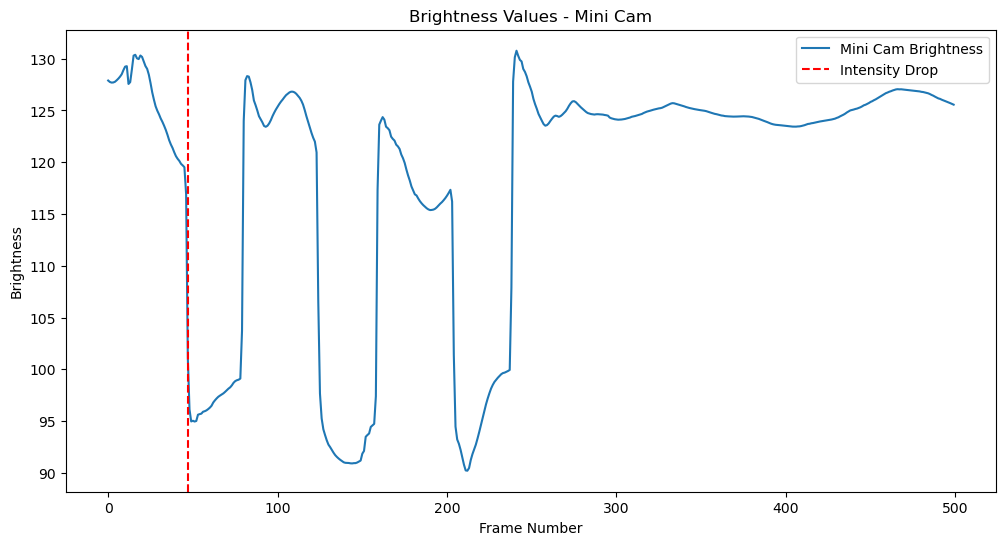

Saved plot to /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241216v1re1f/customEntValHere/2025_05_16/15_27_08/My_WebCam/sync_cam5.png
Saved plot to /data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241216RE2/sync_cam5.png


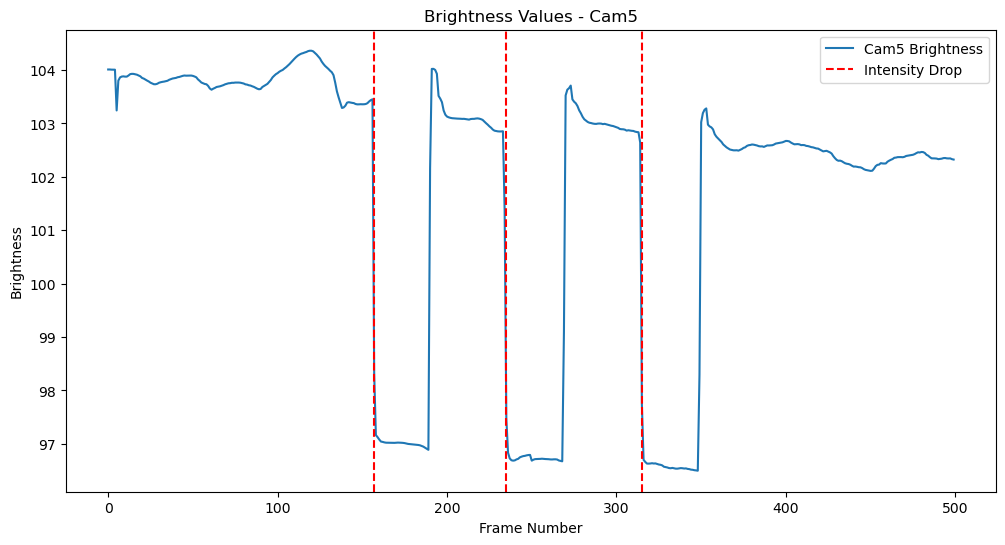

Aligned data saved to /data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241216RE2/MIR_Aligned/only_com_aligned_predictions.h5
Using CA file: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241216v1re1f/customEntValHere/2025_05_16/15_27_08/My_V4_Miniscope/minian_dataset_wnd1500_stp700_max25_diff5.0_pnr1.1.nc
Saved HDF5: /data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241216RE2/MIR_Aligned/only_com_aligned_predictions_with_ca_and_dF_F_wnd1500_stp700_max25_diff5.0_pnr1.1.h5
Saved CSV: /data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241216RE2/MIR_Aligned/only_com_aligned_predictions_with_ca_and_dF_F_wnd1500_stp700_max25_diff5.0_pnr1.1.csv
DEBUG: src exists? True → /data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241216RE2/MIR_Aligned
[mirror] copied MIR_Aligned → /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241216v1re1f/customEntValHere/2025_05_16/15_27_08/MIR_Aligned

Using rec_path: /data/big_rim/rsync_dcc_su

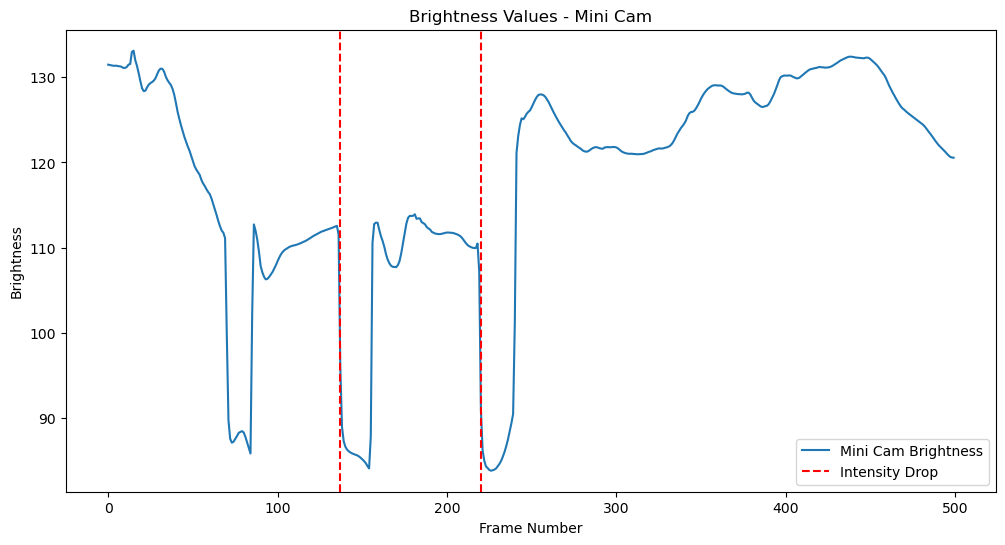

Saved plot to /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241216v1re1f/customEntValHere/2025_05_16/15_42_36/My_WebCam/sync_cam2.png
Saved plot to /data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241224PMCLE1/sync_cam2.png


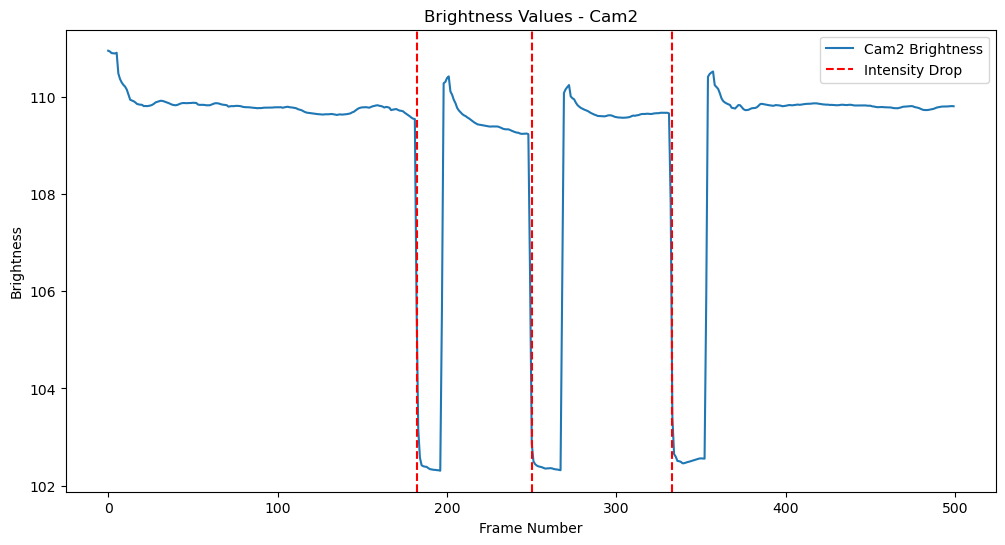

Aligned data saved to /data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241224PMCLE1/MIR_Aligned/only_com_aligned_predictions.h5
Using CA file: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241216v1re1f/customEntValHere/2025_05_16/15_42_36/My_V4_Miniscope/minian_dataset_wnd1500_stp700_max25_diff4.0_pnr1.1.nc
Saved HDF5: /data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241224PMCLE1/MIR_Aligned/only_com_aligned_predictions_with_ca_and_dF_F_wnd1500_stp700_max25_diff4.0_pnr1.1.h5
Saved CSV: /data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241224PMCLE1/MIR_Aligned/only_com_aligned_predictions_with_ca_and_dF_F_wnd1500_stp700_max25_diff4.0_pnr1.1.csv
DEBUG: src exists? True → /data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241224PMCLE1/MIR_Aligned
[mirror] copied MIR_Aligned → /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241216v1re1f/customEntValHere/2025_05_16/15_42_36/MIR_Aligned

Using rec_path: /data/big_rim/

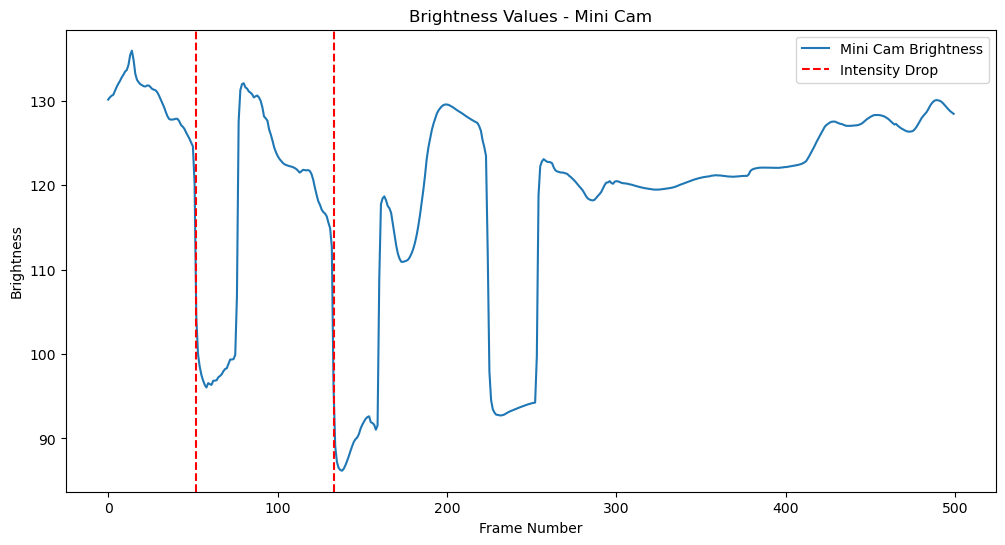

Saved plot to /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20240303PMCBE0coatedr1/customEntValHere/2025_05_16/14_54_15/My_WebCam/sync_cam1.png
Saved plot to /data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20240303PMCBE0r1coatedmini_p20240303RE1/sync_cam1.png


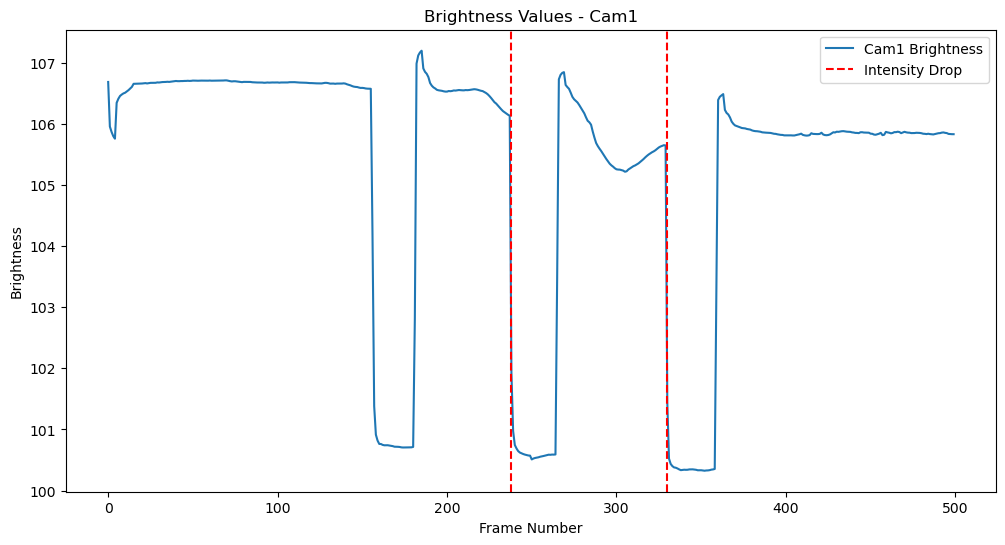

Aligned data saved to /data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20240303PMCBE0r1coatedmini_p20240303RE1/MIR_Aligned/only_com_aligned_predictions.h5
Using CA file: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20240303PMCBE0coatedr1/customEntValHere/2025_05_16/14_54_15/My_V4_Miniscope/minian_dataset_wnd1000_stp700_max15_diff5.0_pnr1.1.nc
Saved HDF5: /data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20240303PMCBE0r1coatedmini_p20240303RE1/MIR_Aligned/only_com_aligned_predictions_with_ca_and_dF_F_wnd1000_stp700_max15_diff5.0_pnr1.1.h5
Saved CSV: /data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20240303PMCBE0r1coatedmini_p20240303RE1/MIR_Aligned/only_com_aligned_predictions_with_ca_and_dF_F_wnd1000_stp700_max15_diff5.0_pnr1.1.csv
DEBUG: src exists? True → /data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20240303PMCBE0r1coatedmini_p20240303RE1/MIR_Aligned
[mirror] copied MIR_Aligned → /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20240303PMCBE0coatedr1/customEntValHere/2025_05_16/14_54_15/MIR_Ali

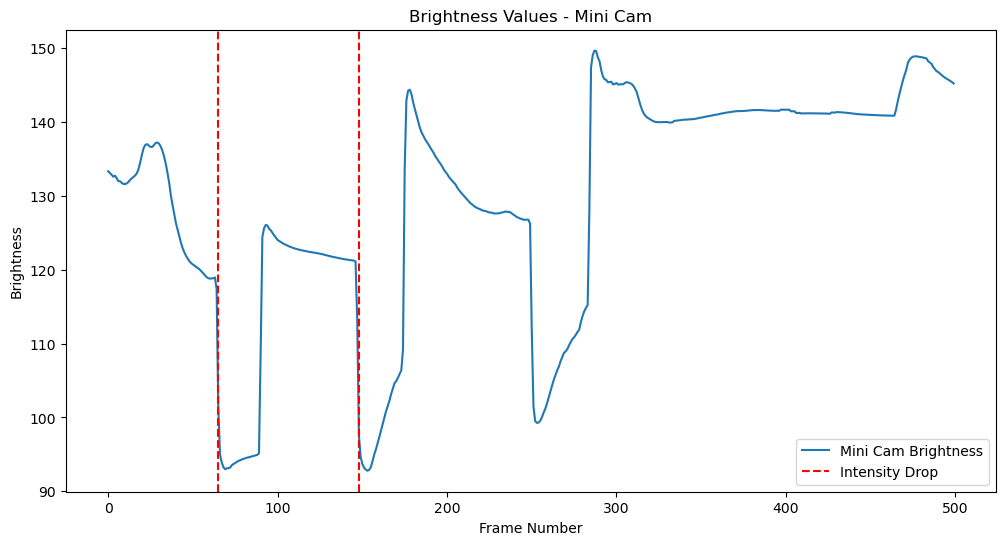

Saved plot to /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20240919-V1-R2/customEntValHere/2024_12_31/14_05_14/My_WebCam/sync_cam2.png
Saved plot to /data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_p20240717PMC_social_14_04/sync_cam2.png


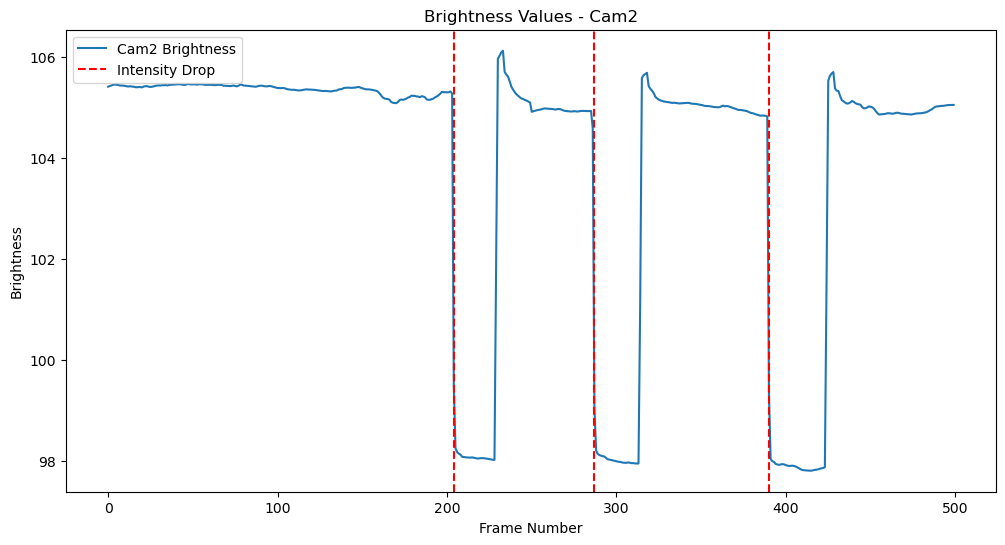

Aligned data saved to /data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_p20240717PMC_social_14_04/MIR_Aligned/only_com_aligned_predictions.h5
Using CA file: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20240919-V1-R2/customEntValHere/2024_12_31/14_05_14/My_V4_Miniscope/minian_dataset_wnd1000_stp700_max25_diff5.0_pnrauto.nc
Saved HDF5: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_p20240717PMC_social_14_04/MIR_Aligned/only_com_aligned_predictions_with_ca_and_dF_F_wnd1000_stp700_max25_diff5.0_pnrauto.h5
Saved CSV: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_p20240717PMC_social_14_04/MIR_Aligned/only_com_aligned_predictions_with_ca_and_dF_F_wnd1000_stp700_max25_diff5.0_pnrauto.csv
DEBUG: src exists? True → /data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_p20240717PMC_social_14_04/MIR_Aligned
[mirror] copied MIR_Aligned → /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20240919-V1-R2/customEntValHere/2024_12_31/14_05_14/

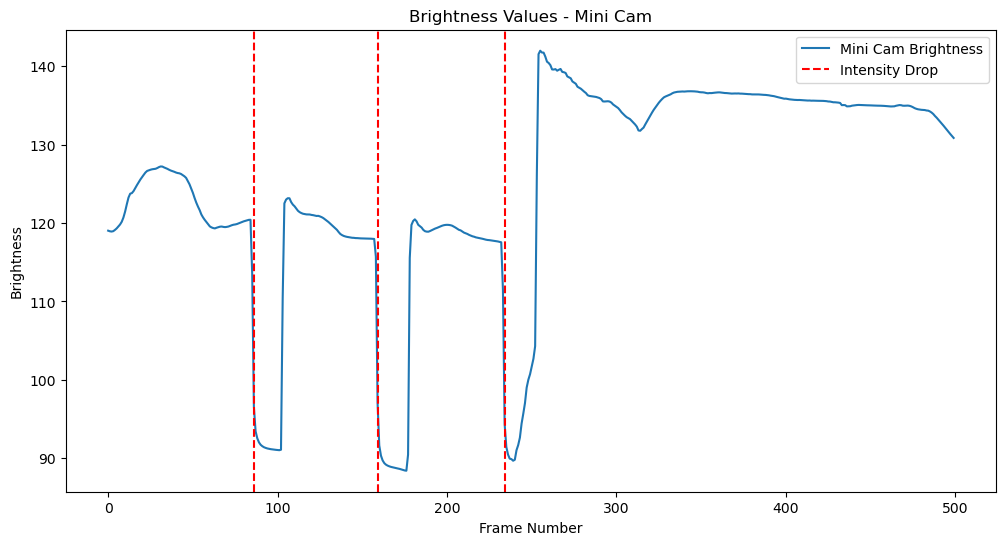

Saved plot to /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241015PMCBE1/customEntValHere/2025_02_27/12_34_44/My_WebCam/sync_cam1.png
Saved plot to /data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/20241015PMCBE1mini_p20241015PMCRE1_12_33/sync_cam1.png


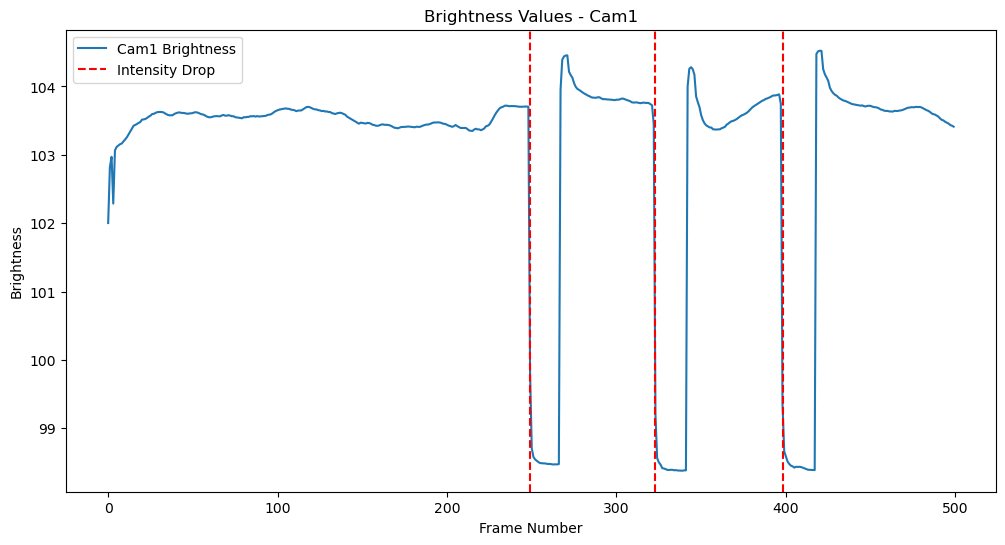

Aligned data saved to /data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/20241015PMCBE1mini_p20241015PMCRE1_12_33/MIR_Aligned/only_com_aligned_predictions.h5
Using CA file: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241015PMCBE1/customEntValHere/2025_02_27/12_34_44/My_V4_Miniscope/minian_dataset_wnd1500_stp700_max15_diff3.5_pnr1.1.nc
Saved HDF5: /data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/20241015PMCBE1mini_p20241015PMCRE1_12_33/MIR_Aligned/only_com_aligned_predictions_with_ca_and_dF_F_wnd1500_stp700_max15_diff3.5_pnr1.1.h5
Saved CSV: /data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/20241015PMCBE1mini_p20241015PMCRE1_12_33/MIR_Aligned/only_com_aligned_predictions_with_ca_and_dF_F_wnd1500_stp700_max15_diff3.5_pnr1.1.csv
DEBUG: src exists? True → /data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/20241015PMCBE1mini_p20241015PMCRE1_12_33/MIR_Aligned
[mirror] copied MIR_Aligned → /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241015PMCBE1/customEntValHere/2025_02_27/12_34_44/MIR_Aligned

Using 

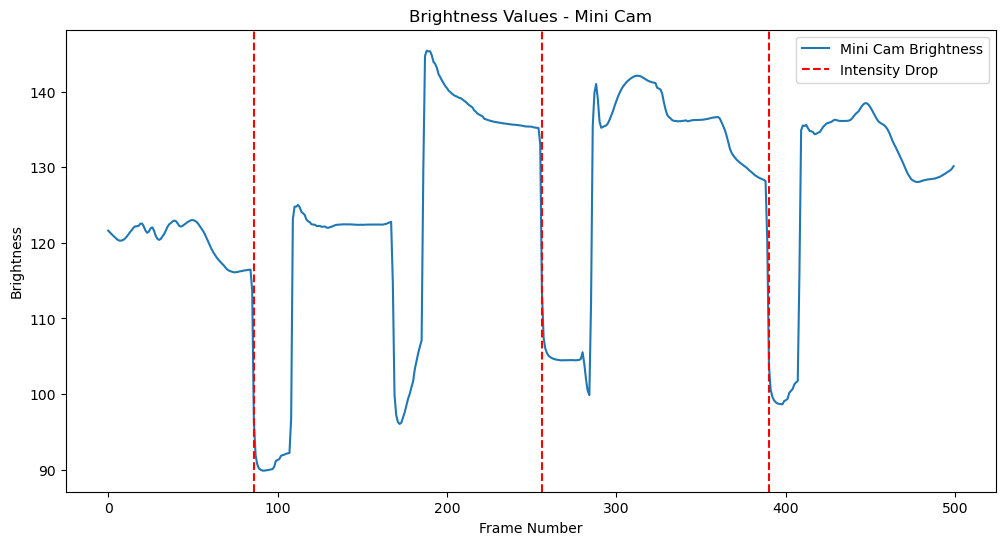

Saved plot to /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20240919-V1-R1/customEntValHere/2024_12_18/11_33_01/My_WebCam/sync_cam4.png
Saved plot to /data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_p20240717PMC_social_test_11_30/sync_cam4.png


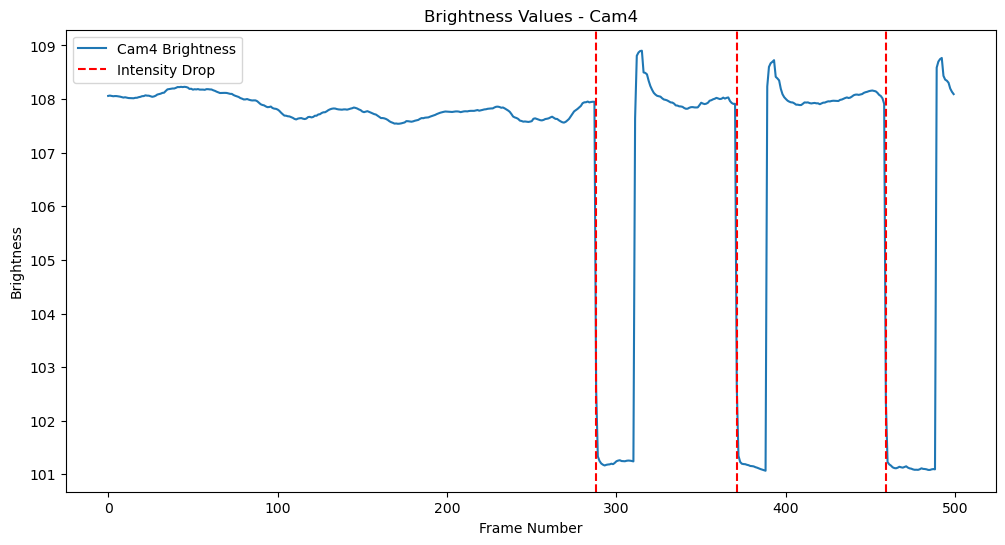

Aligned data saved to /data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_p20240717PMC_social_test_11_30/MIR_Aligned/only_com_aligned_predictions.h5
Using CA file: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20240919-V1-R1/customEntValHere/2024_12_18/11_33_01/My_V4_Miniscope/minian_dataset_wnd700_stp700_max25_diff4.0_pnrauto.nc
Saved HDF5: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_p20240717PMC_social_test_11_30/MIR_Aligned/only_com_aligned_predictions_with_ca_and_dF_F_wnd700_stp700_max25_diff4.0_pnrauto.h5
Saved CSV: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_p20240717PMC_social_test_11_30/MIR_Aligned/only_com_aligned_predictions_with_ca_and_dF_F_wnd700_stp700_max25_diff4.0_pnrauto.csv
DEBUG: src exists? True → /data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_p20240717PMC_social_test_11_30/MIR_Aligned
[mirror] copied MIR_Aligned → /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20240919-V1-R1/customEntValHere/202

In [8]:
import os
import sys
import glob
import pandas as pd
import shutil

# Add project root so that the functions can be imported
sys.path.append(os.path.abspath('../..'))
from utlis.sync_utlis.mini_dannce_sync import (
    run_mini_dannce_sync
)

def extract_mini_directory(raw_mini_path):
    """
    Normalize the mini_path for downstream processing.
    If raw_mini_path ends with 'My_V4_Miniscope', remove that folder.
    Otherwise, return the normalized path with a trailing slash.
    """
    norm_path = os.path.normpath(raw_mini_path)
    if os.path.basename(norm_path) == "My_V4_Miniscope":
        cleaned = os.path.dirname(norm_path)
    else:
        cleaned = norm_path
    if not cleaned.endswith(os.sep):
        cleaned += os.sep
    return cleaned

def extract_mini_directory_for_nc(raw_mini_path):
    """
    Normalize the mini_path for mapping lookup.
    This version does NOT remove 'My_V4_Miniscope' and simply
    returns the normalized path with a trailing slash.
    """
    norm_path = os.path.normpath(raw_mini_path)
    if not norm_path.endswith(os.sep):
        norm_path += os.sep
    return norm_path

def normalize_rec_directory(raw_rec_path):
    """
    Given a path read from the .txt file, ensure it is normalized
    and ends with a trailing slash. Do not strip any subfolders.
    """
    norm_path = os.path.normpath(raw_rec_path)
    if not norm_path.endswith(os.sep):
        norm_path += os.sep
    return norm_path

def extract_name_suffix(nc_file_path):
    """
    Given a full path to an .nc file, extract a suffix from the filename.
    For example, if the file is named:
      minian_dataset_wnd1000_stp700_max15_diff3.5_pnrauto.nc
    then return: wnd1000_stp700_max15_diff3.5_pnrauto
    If the filename does not follow the expected pattern, return an empty string.
    """
    nc_basename = os.path.basename(nc_file_path)
    prefix = "minian_dataset_"
    suffix = ".nc"
    if nc_basename.startswith(prefix) and nc_basename.endswith(suffix):
        return nc_basename[len(prefix):-len(suffix)]
    return ""

def mirror_MIR_Aligned(rec_path, mini_path):
    src = os.path.join(rec_path, "MIR_Aligned")
    dst = os.path.join(mini_path, "MIR_Aligned")
    print(f"DEBUG: src exists? {os.path.isdir(src)} → {src}")
    if not os.path.isdir(src):
        print(f"[mirror] no MIR_Aligned at {src}")
        return
    os.makedirs(dst, exist_ok=True)
    shutil.copytree(src, dst, dirs_exist_ok=True)
    print(f"[mirror] copied MIR_Aligned → {dst}")

def process_good_minis(csv_path, nc_csv_path, dry_run=True, only_com=False):
    """
    Process all minis whose 'condition' is 'good' or 'good_vein',
    look up their rec_path via a .txt file in the parent directory of My_V4_Miniscope,
    find the right .nc file, and run alignment.
    Falls back to 'minian_dataset.nc' if no suffix/key is available.
    """
    # 1) load and filter
    df = pd.read_csv(csv_path)
    df_filtered = df[df['condition'].isin(["good", "good_vein"])]

    for _, row in df_filtered.iterrows():
        raw_mini_path = row["rec_path"]

        # Normalize mini directory (strip "My_V4_Miniscope" if present)
        mini_dir = extract_mini_directory(raw_mini_path)

        # Find *.txt file in that directory
        txt_candidates = glob.glob(os.path.join(mini_dir, "*.txt"))
        if not txt_candidates:
            print(f"No .txt mapping file found in {mini_dir}; skipping.")
            continue

        # Take the first .txt file found
        mapping_txt = txt_candidates[0]
        try:
            with open(mapping_txt, 'r') as f:
                raw_rec_path = f.read().strip()
        except Exception as e:
            print(f"Error reading {mapping_txt}: {e}; skipping.")
            continue

        if not raw_rec_path:
            print(f"No rec_path inside {mapping_txt}; skipping.")
            continue

        # Normalize rec_path exactly as given (no extra dirname stripping)
        rec_path = normalize_rec_directory(raw_rec_path)
        mini_path = mini_dir
        mapping_key = extract_mini_directory_for_nc(raw_mini_path)

        print(f"\nUsing rec_path: {rec_path}  for mini_path: {mini_path}")

        # define output markers
        dannce_file = os.path.join(rec_path, "DANNCE", "predict00", "save_data_AVG.mat")
        mir_base    = os.path.join(rec_path, "MIR_Aligned")

        # gather all .nc files in the miniscope folder
        nc_folder = raw_mini_path
        nc_files  = glob.glob(os.path.join(nc_folder, "*.nc"))
        selected_nc_file = None

        # ---- single-file case ----
        if len(nc_files) == 1:
            basename = os.path.basename(nc_files[0])
            if basename.startswith("minian_dataset_") and basename.endswith(".nc"):
                keyyy = basename[len("minian_dataset_"):-3]
                selected_nc_file = nc_files[0]
                print(f"key: {keyyy}")
            else:
                keyyy = ""
                selected_nc_file = os.path.join(nc_folder, "minian_dataset.nc")
                print("using default mini.nc")

            print(f"Selected .nc file: {selected_nc_file} (key='{keyyy}')")

            mir_base = os.path.join(rec_path, "MIR_Aligned")
            if os.path.isdir(mir_base):
                h5_files = [
                    fn for fn in os.listdir(mir_base)
                    if fn.endswith(".h5") and "aligned_predictions_with_ca_and_dF_F" in fn
                ]
            else:
                h5_files = []

            if only_com:
                mir_done = bool(h5_files)
            else:
                mir_done = any(not fn.startswith("only_com_") for fn in h5_files)

            if mir_done:
                print("Alignment already done; skipping.")
                continue

            if not dry_run:
                run_mini_dannce_sync(rec_path, mini_path, keyyy or None, only_com)
                mirror_MIR_Aligned(rec_path, mini_path)

        # ---- multiple-file case ----
        else:
            if os.path.exists(nc_csv_path):
                nc_map_df = pd.read_csv(nc_csv_path)
                for _, map_row in nc_map_df.iterrows():
                    map_rec = extract_mini_directory_for_nc(map_row["rec_path"])
                    if map_rec in mapping_key or mapping_key in map_rec:
                        key = map_row["nc_file"]
                        print(f"key of nc: {key}")
                        candidate = os.path.join(nc_folder, f"minian_dataset_{key}.nc")
                        if os.path.isfile(candidate):
                            selected_nc_file = candidate
                            print(f"Selected from mapping: {selected_nc_file}")

                            mir_base = os.path.join(rec_path, "MIR_Aligned")
                            if os.path.isdir(mir_base):
                                h5_files = [
                                    fn for fn in os.listdir(mir_base)
                                    if fn.endswith(".h5") and "aligned_predictions_with_ca_and_dF_F" in fn
                                ]
                            else:
                                h5_files = []

                            if only_com:
                                mir_done = bool(h5_files)
                            else:
                                mir_done = any(not fn.startswith("only_com_") for fn in h5_files)

                            if mir_done:
                                print(f"[skip] already aligned for key={key}; skipping.")
                                break

                            if not dry_run:
                                run_mini_dannce_sync(rec_path, mini_path, key, only_com)
                                mirror_MIR_Aligned(rec_path, mini_path)
                            break

            # if still nothing matched, fallback
            if not selected_nc_file:
                selected_nc_file = os.path.join(nc_folder, "minian_dataset.nc")
                print(f"No mapping key found; falling back to {selected_nc_file}")
                if not dry_run:
                    run_mini_dannce_sync(rec_path, mini_path, None, only_com)
                    mirror_MIR_Aligned(rec_path, mini_path)

# For a Jupyter Notebook run, simply call the function:
process_good_minis(
    csv_path="/home/lq53/mir_repos/BBOP/random_tests/25may_mini/mini_sanity_240603_mannual.csv",
    nc_csv_path="/home/lq53/mir_repos/BBOP/random_tests/25may_mini/mini_nc_mapping_250604.csv",
    dry_run=False,#True,
    only_com=True
)


In [ ]:
#will remove all. should not use that easily

# import os
# import glob
# import shutil

# def remove_all_MIR_Aligned(root_dir):
#     """
#     Finds every MIR_Aligned directory under root_dir and
#     deletes each directory and its contents.
#     """
#     # Recursively locate all MIR_Aligned folders
#     mir_dirs = glob.glob(os.path.join(root_dir, '**', 'MIR_Aligned'), recursive=True)
#     for mir_dir in mir_dirs:
#         try:
#             # shutil.rmtree(mir_dir)
#             print(f"Removed directory: {mir_dir}")
#         except Exception as e:
#             print(f"Failed to remove {mir_dir}: {e}")

# # Example usage:
# # set this to your top-level recordings folder
# root = "/data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted" #'/data/big_rim/rsync_dcc_sum/Oct3V1'
# remove_all_MIR_Aligned(root)


Removed directory: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20240919-V1-R1/customEntValHere/2024_12_18/11_22_07/MIR_Aligned
Removed directory: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20240910-V1-R/customEntValHere/2024_11_01/12_52_48/MIR_Aligned
Removed directory: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20240910-V1-R/customEntValHere/2024_11_01/13_09_59/MIR_Aligned
Removed directory: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20240910-V1-R/customEntValHere/2024_11_01/11_39_00/MIR_Aligned
Removed directory: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20240819-V1-r1/customEntValHere/2024_11_01/14_40_33/MIR_Aligned
Removed directory: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20240819-V1-r1/customEntValHere/2024_11_01/14_57_45/MIR_Aligned
Removed directory: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20240819-V1-r1/customEntValHere/2024_10_31/11_31_56/MIR_Aligned
Removed directory: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20240819-V1-r1/customEntValHere/202

In [ ]:
# below is just try to generate the mapping.json file....


import os
import sys
import json
import glob
import pandas as pd

# Add project root so that the functions can be imported
sys.path.append(os.path.abspath('../..'))
from utlis.sync_utlis.mini_dannce_sync import (
    # sync_videos,
    # align_miniscope_to_sixcam,
    # load_aligneddannce_and_process_ca_data,
    # load_aligneddannce_and_process_ca_data_custom,
    run_mini_dannce_sync
)

def extract_mini_directory(raw_mini_path):
    """
    Normalize the mini_path for downstream processing.
    If raw_mini_path ends with 'My_V4_Miniscope', remove that folder.
    Otherwise, return the normalized path with a trailing slash.
    """
    norm_path = os.path.normpath(raw_mini_path)
    if os.path.basename(norm_path) == "My_V4_Miniscope":
        cleaned = os.path.dirname(norm_path)
    else:
        cleaned = norm_path
    if not cleaned.endswith(os.sep):
        cleaned += os.sep
    return cleaned

def extract_mini_directory_for_nc(raw_mini_path):
    """
    Normalize the mini_path for mapping lookup.
    This version does NOT remove 'My_V4_Miniscope' and simply
    returns the normalized path with a trailing slash.
    """
    norm_path = os.path.normpath(raw_mini_path)
    if not norm_path.endswith(os.sep):
        norm_path += os.sep
    return norm_path

def extract_rec_directory(raw_rec_path):
    """
    Given a full rec_path (including a filename), return only its parent directory, ensuring a trailing slash.
    """
    parent_dir = os.path.dirname(os.path.dirname(os.path.dirname(raw_rec_path)))
    if not parent_dir.endswith(os.sep):
        parent_dir += os.sep
    return parent_dir

def extract_name_suffix(nc_file_path):
    """
    Given a full path to an .nc file, extract a suffix from the filename.
    For example, if the file is named:
      minian_dataset_wnd1000_stp700_max15_diff3.5_pnrauto.nc
    then return: wnd1000_stp700_max15_diff3.5_pnrauto
    If the filename does not follow the expected pattern, return an empty string.
    """
    nc_basename = os.path.basename(nc_file_path)
    prefix = "minian_dataset_"
    suffix = ".nc"
    if nc_basename.startswith(prefix) and nc_basename.endswith(suffix):
        return nc_basename[len(prefix):-len(suffix)]
    return ""

def get_rec_path_for_mini(raw_mini_path, mapping):
    """
    Given the raw mini_path and a mapping dictionary, return its corresponding rec_path.
    """
    if raw_mini_path not in mapping:
        raise KeyError(f"Key '{raw_mini_path}' not found in mapping.")
    return mapping[raw_mini_path].get("rec_path")

def process_good_minis(csv_path, json_path, nc_csv_path, dry_run=False):
    """
    Process minis using file locations specified by the caller.
    """
    # Read the main CSV and filter rows by condition.
    df = pd.read_csv(csv_path)
    df_filtered = df[df['condition'].isin(["good", "good_vein"])]
    
    # Load the JSON mapping from mini_path to rec_path.
    with open(json_path, 'r') as f:
        mini_to_rec = json.load(f)
    
    # Process each filtered mini entry.
    for idx, row in df_filtered.iterrows():
        raw_mini_path = row["rec_path"]  # Using the value from the main CSV.
        try:
            raw_rec_path = get_rec_path_for_mini(raw_mini_path, mini_to_rec)
        except KeyError as e:
            print(e)
            continue
        print("\n")
        # print("\nraw_rec_path:", raw_rec_path)
        if raw_rec_path:
            # For alignment processing, use the cleaned mini path (removes My_V4_Miniscope if needed).
            mini_path = extract_mini_directory(raw_mini_path)
            # For mapping lookup, use the full normalized path.
            mapping_key = extract_mini_directory_for_nc(raw_mini_path)
            rec_path = extract_rec_directory(raw_rec_path)
            
            print("Using matched rec_path:", rec_path, "for mini_path:", mini_path)
            
            # Find .nc files in the miniscope folder.
            nc_folder = raw_mini_path  # This may include the My_V4_Miniscope subfolder.
            nc_files = glob.glob(os.path.join(nc_folder, "*.nc"))
            # print(nc_files)
            selected_nc_file = None
            
            dannce_file = os.path.join(rec_path, "DANNCE", "predict00", "save_data_AVG.mat")
            mir_file = os.path.join(rec_path, "MIR_Aligned", "aligned_predictions_with_ca_and_dF_F.h5")

            if len(nc_files) == 0 or nc_files == [] or nc_files is None:
                print(f"No .nc files found in {nc_folder}.")
            elif len(nc_files) == 1:
                selected_nc_file = nc_files[0]
                print(f"Found single .nc file: {selected_nc_file}")
                # print("checking status...")
                # Check if alignment has already been completed.
                if os.path.exists(dannce_file) and os.path.exists(mir_file):
                    print(f"Alignment already completed for rec_path: {rec_path}. Skipping further processing for this mini.")
                    continue  # Skip to next mini entry if alignment exists.
                else:
                    
                    # print("only found 1 nc file and not processed")
                    keyyy = extract_name_suffix(nc_files[0])
                    mir_file = os.path.join(rec_path, "MIR_Aligned", f"aligned_predictions_with_ca_and_dF_F_{keyyy}.h5")
                    print(mir_file)
                    if os.path.exists(mir_file):
                        print(f"Alignment already completed for rec_path: {rec_path}. Skipping further processing for this mini.")
                        continue  # Skip to next mini entry if alignment exists.
                    print(f"process the only 1 nc file {nc_files}")
                    run_mini_dannce_sync(rec_path, mini_path, keyyy)

            else:
                # Debug information when multiple .nc files are found.
                # print("DEBUG: Multiple .nc files found in folder:", nc_folder)
                # print("DEBUG: List of .nc files:", nc_files)
                # print("DEBUG: Current cleaned mini_path:", mini_path)
                # print("DEBUG: Mapping lookup key:", mapping_key)
                
                # New logic: iterate through the nc mapping CSV rows and check if the rec_path
                # from the mapping is (partially) contained in the current mini_path.
                if os.path.exists(nc_csv_path):
                    nc_mapping_df = pd.read_csv(nc_csv_path)
                    # print("DEBUG: nc_mapping_df columns:", nc_mapping_df.columns.tolist())
                    # print("DEBUG: nc_mapping_df head:\n", nc_mapping_df.head())
                    
                    for idx_map, mapping_row in nc_mapping_df.iterrows():
                        mapping_rec_path = extract_mini_directory_for_nc(mapping_row["rec_path"])
                        # Check if there's a substring match between the mapping rec_path and the current mini_path.
                        if mapping_rec_path in mapping_key or mapping_key in mapping_rec_path:
                            # Construct the file name using the key from the CSV.
                            key = mapping_row["nc_file"]
                            filename = f"minian_dataset_{key}.nc"
                            selected_nc_file = os.path.join(nc_folder, filename)
                            print(f"Selected .nc file from mapping: {selected_nc_file}")
                            mir_file = os.path.join(rec_path, "MIR_Aligned", f"aligned_predictions_with_ca_and_dF_F_{key}.h5")
                            print(mir_file)
                            # if os.path.exists(mir_file):
                            #     print(f"Alignment already completed for rec_path: {rec_path}. Skipping further processing for this mini.")
                            #     continue  # Skip to next mini entry if alignment exists.
                            if not os.path.exists(dannce_file):
                                print(f"Need to make dannce predictions first....")
                                continue  # Skip to next mini entry if alignment exists.
                            try:
                                print("key",key)
                                run_mini_dannce_sync(rec_path, mini_path, key)
                                
                                # print("Alignment function called (currently commented out).")
                            except (TypeError, IndexError) as e:
                                print(f"Error during alignment for mini_path: {mini_path}. Skipping this mini. Error: {e}")
                                continue
                    if not selected_nc_file:
                        print("no .nc file matched found")
                        print("Using matched rec_path:", rec_path, "for mini_path:", mini_path)
                else:
                    print("nc_csv_path does not exist. Cannot perform mapping lookup.")
                # print("Starting alignment process...")
                
            
            # Start the alignment process (currently commented out).
            
        else:
            print(f"No matching rec_path found for mini_path: {raw_mini_path}")

# For a Jupyter Notebook run, simply call the function:
process_good_minis(
    csv_path="/home/lq53/mir_repos/BBOP/random_tests/25mar_minibbop_integration/mini_sanity_240331_updated_nc_select.csv",
    json_path="/home/lq53/mir_repos/BBOP/random_tests/25mar_minibbop_integration/mini_to_rec_mapping.json",
    nc_csv_path="/home/lq53/mir_repos/BBOP/random_tests/25mar_minibbop_integration/mini_nc_mapping_250327.csv"
)


In [ ]:
# below not working
#  import os
# import sys
# import json
# import glob
# import pandas as pd

# # Add project root so that the functions can be imported
# sys.path.append(os.path.abspath('../..'))
# from utlis.sync_utlis.mini_dannce_sync import (
#     sync_videos,
#     align_miniscope_to_sixcam,
#     load_aligneddannce_and_process_ca_data,
#     load_aligneddannce_and_process_ca_data_custom,
#     run_mini_dannce_sync
# )

# def extract_mini_directory(raw_mini_path):
#     """
#     Normalize the mini_path for downstream processing.
#     If raw_mini_path ends with 'My_V4_Miniscope', remove that folder.
#     Otherwise, return the normalized path with a trailing slash.
#     """
#     norm_path = os.path.normpath(raw_mini_path)
#     if os.path.basename(norm_path) == "My_V4_Miniscope":
#         cleaned = os.path.dirname(norm_path)
#     else:
#         cleaned = norm_path
#     if not cleaned.endswith(os.sep):
#         cleaned += os.sep
#     return cleaned

# def extract_mini_directory_for_nc(raw_mini_path):
#     """
#     Normalize the mini_path for mapping lookup.
#     This version does NOT remove 'My_V4_Miniscope' and simply
#     returns the normalized path with a trailing slash.
#     """
#     norm_path = os.path.normpath(raw_mini_path)
#     if not norm_path.endswith(os.sep):
#         norm_path += os.sep
#     return norm_path

# def extract_rec_directory(raw_rec_path):
#     """
#     Given a full rec_path (including a filename), return only its parent directory, ensuring a trailing slash.
#     """
#     parent_dir = os.path.dirname(os.path.dirname(os.path.dirname(raw_rec_path)))
#     if not parent_dir.endswith(os.sep):
#         parent_dir += os.sep
#     return parent_dir

# def extract_name_suffix(nc_file_path):
#     """
#     Given a full path to an .nc file, extract a suffix from the filename.
#     For example, if the file is named:
#       minian_dataset_wnd1000_stp700_max15_diff3.5_pnrauto.nc
#     then return: wnd1000_stp700_max15_diff3.5_pnrauto
#     If the filename does not follow the expected pattern, return an empty string.
#     """
#     nc_basename = os.path.basename(nc_file_path)
#     prefix = "minian_dataset_"
#     suffix = ".nc"
#     if nc_basename.startswith(prefix) and nc_basename.endswith(suffix):
#         return nc_basename[len(prefix):-len(suffix)]
#     return ""

# def get_rec_path_for_mini(raw_mini_path, mapping):
#     """
#     Given the raw mini_path and a mapping dictionary, return its corresponding rec_path.
#     """
#     if raw_mini_path not in mapping:
#         raise KeyError(f"Key '{raw_mini_path}' not found in mapping.")
#     return mapping[raw_mini_path].get("rec_path")

# def process_good_minis(csv_path, json_path, nc_csv_path, dry_run=False):
#     """
#     Process minis using file locations specified by the caller.
    
#     Parameters:
#         csv_path (str): Path to the CSV file containing mini information.
#         json_path (str): Path to the JSON mapping file.
#         nc_csv_path (str): Path to the CSV mapping file for selecting .nc files.
#         dry_run (bool): If True, only print the discovered file paths without executing the heavy processing.
#     """
#     # Read the main CSV and filter rows by condition.
#     df = pd.read_csv(csv_path)
#     df_filtered = df[df['condition'].isin(["good", "good_vein"])]
    
#     # Load the JSON mapping from mini_path to rec_path.
#     with open(json_path, 'r') as f:
#         mini_to_rec = json.load(f)
    
#     # Load the CSV mapping for .nc files.
#     if os.path.exists(nc_csv_path):
#         nc_mapping_df = pd.read_csv(nc_csv_path)
#         print("DEBUG: nc_mapping_df columns:", nc_mapping_df.columns.tolist())
#         print("DEBUG: nc_mapping_df head:\n", nc_mapping_df.head())
        
#         # Build dictionary using the normalized path for nc mapping.
#         # Note: using extract_mini_directory_for_nc so the key retains "My_V4_Miniscope" if present.
#         nc_mapping_dict = {
#             extract_mini_directory_for_nc(rec_path): nc_file
#             for rec_path, nc_file in zip(nc_mapping_df["rec_path"], nc_mapping_df["nc_file"])
#         }
#         print("DEBUG: nc_mapping_dict keys:", list(nc_mapping_dict.keys()))
#     else:
#         nc_mapping_dict = {}
    
#     # Process each filtered mini entry.
#     for idx, row in df_filtered.iterrows():
#         raw_mini_path = row["rec_path"]  # Using the value from the main CSV.
#         try:
#             raw_rec_path = get_rec_path_for_mini(raw_mini_path, mini_to_rec)
#         except KeyError as e:
#             print(e)
#             continue

#         print("\nraw_rec_path:", raw_rec_path)
#         if raw_rec_path:
#             # For alignment processing, use the cleaned mini path (removes My_V4_Miniscope if needed).
#             mini_path = extract_mini_directory(raw_mini_path)
#             # For nc mapping lookup, use the full normalized path.
#             mapping_key = extract_mini_directory_for_nc(raw_mini_path)
#             rec_path = extract_rec_directory(raw_rec_path)
            
#             print("Using matched rec_path:", rec_path, "for mini_path:", mini_path)
            
#             # Find .nc files in the miniscope folder.
#             nc_folder = raw_mini_path  # This may include the My_V4_Miniscope subfolder.
#             nc_files = glob.glob(os.path.join(nc_folder, "*.nc"))
#             selected_nc_file = None
            
#             if len(nc_files) == 0:
#                 print(f"No .nc files found in {nc_folder}.")
#             elif len(nc_files) == 1:
#                 selected_nc_file = nc_files[0]
#                 print(f"Found single .nc file: {selected_nc_file}")
#             else:
#                 # Debug information when multiple .nc files are found.
#                 print("DEBUG: Multiple .nc files found in folder:", nc_folder)
#                 print("DEBUG: List of .nc files:", nc_files)
#                 print("DEBUG: Current cleaned mini_path:", mini_path)
#                 print("DEBUG: Mapping lookup key:", mapping_key)
#                 print("DEBUG: Available keys in nc_mapping_dict:", list(nc_mapping_dict.keys()))
                
#                 if mapping_key in nc_mapping_dict:
#                     mapped_substring = nc_mapping_dict[mapping_key]
#                     potential_path = os.path.join(nc_folder, mapped_substring)
#                     if os.path.exists(potential_path):
#                         selected_nc_file = potential_path
#                         print(f"Selected .nc file from mapping: {selected_nc_file}")
#                     else:
#                         # If the exact file is not found, try to find one containing the mapping substring.
#                         found_match = False
#                         for file in nc_files:
#                             if mapped_substring in os.path.basename(file):
#                                 selected_nc_file = file
#                                 found_match = True
#                                 print(f"Selected .nc file matching substring from mapping: {selected_nc_file}")
#                                 break
#                         if not found_match:
#                             print(f"Mapped .nc file '{mapped_substring}' not found in {nc_folder}. Using first found file: {nc_files[0]}")
#                             selected_nc_file = nc_files[0]
#                 else:
#                     print(f"Multiple .nc files found in {nc_folder} but no mapping entry exists for key: {mapping_key}. Using first found file: {nc_files[0]}")
#                     selected_nc_file = nc_files[0]
            
#             # Extract parameter suffix from the .nc filename, if applicable.
#             name_suffix = ""
#             if selected_nc_file:
#                 name_suffix = extract_name_suffix(selected_nc_file)
#                 if name_suffix:
#                     print(f"Extracted name suffix: {name_suffix}")
#                 else:
#                     print("No name suffix extracted from the .nc filename.")
            
#             # Construct expected alignment file paths.
#             dannce_file = os.path.join(rec_path, "DANNCE", "predict00", "save_data_AVG.mat")
#             mir_file = os.path.join(rec_path, "MIR_Aligned", "aligned_predictions_with_ca_and_dF_F.h5")

#             print("checking status...")
#             # Check if alignment has already been completed.
#             if os.path.exists(dannce_file) and os.path.exists(mir_file):
#                 print(f"Alignment already completed for rec_path: {rec_path}. Skipping further processing for this mini.")
#                 continue  # Skip to next mini entry if alignment exists.
            
#             # If alignment is not done, perform alignment.
#             print("Starting alignment process...")
#             try:
#                 # Uncomment the following lines to enable alignment:
#                 # resultsss = sync_videos(
#                 #     rec_path,
#                 #     mini_path,
#                 #     start_frame=0,
#                 #     end_frame=200,
#                 #     threshold_mini=15,
#                 #     threshold_sixcam=3
#                 # )
#                 # align_miniscope_to_sixcam(resultsss, mini_path, rec_path)
#                 print("Alignment function called (currently commented out).")
#             except (TypeError, IndexError) as e:
#                 print(f"Error during align_miniscope_to_sixcam for mini_path: {mini_path}. Skipping this mini. Error: {e}")
#                 continue
            
#             # Step 2: Load alignment and process calcium data.
#             if selected_nc_file:
#                 # Uncomment the following line to process with the custom .nc file:
#                 # df_merged_with_dF_F = load_aligneddannce_and_process_ca_data_custom(
#                 #     rec_path,
#                 #     mini_path,
#                 #     nc_file=selected_nc_file,
#                 #     # name_suffix=name_suffix
#                 # )
#                 print("Processing with custom .nc file (function call commented out).")
#             else:
#                 # Uncomment the following line to process without the custom .nc file:
#                 # df_merged_with_dF_F = load_aligneddannce_and_process_ca_data(rec_path, mini_path)
#                 print("Processing without custom .nc file (function call commented out).")
#         else:
#             print(f"No matching rec_path found for mini_path: {raw_mini_path}")

# # For a Jupyter Notebook run, simply call the function:
# process_good_minis(
#     csv_path="/home/lq53/mir_repos/BBOP/random_tests/25mar_minibbop_integration/mini_sanity_240324_mannual.csv",
#     json_path="/home/lq53/mir_repos/BBOP/random_tests/25mar_minibbop_integration/mini_to_rec_mapping.json",
#     nc_csv_path="/home/lq53/mir_repos/BBOP/random_tests/25mar_minibbop_integration/mini_nc_mapping_250327.csv"
# )

In [ ]:
# import os
# import sys
# import json
# import glob
# import pandas as pd

# # Add project root so that the functions can be imported
# sys.path.append(os.path.abspath('../..'))
# from utlis.sync_utlis.mini_dannce_sync import (
#     sync_videos,
#     align_miniscope_to_sixcam,
#     load_aligneddannce_and_process_ca_data,
#     load_aligneddannce_and_process_ca_data_custom
# )

# def get_rec_path_for_mini(raw_mini_path, mapping):
#     """
#     Given the raw mini_path and a mapping dictionary, return its corresponding rec_path.
#     """
#     if raw_mini_path not in mapping:
#         raise KeyError(f"Key '{raw_mini_path}' not found in mapping.")
#     return mapping[raw_mini_path].get("rec_path")

# def extract_mini_directory(raw_mini_path):
#     """
#     If raw mini_path ends with 'My_V4_Miniscope', remove that folder and return its parent directory (with trailing slash).
#     Otherwise, ensure the path ends with a slash.
#     """
#     norm_path = os.path.normpath(raw_mini_path)
#     if os.path.basename(norm_path) == "My_V4_Miniscope":
#         cleaned = os.path.dirname(norm_path)
#     else:
#         cleaned = norm_path
#     if not cleaned.endswith(os.sep):
#         cleaned += os.sep
#     return cleaned

# def extract_rec_directory(raw_rec_path):
#     """
#     Given a full rec_path (including a filename), return only its parent directory, ensuring a trailing slash.
#     """
#     parent_dir = os.path.dirname(os.path.dirname(os.path.dirname(raw_rec_path)))
#     if not parent_dir.endswith(os.sep):
#         parent_dir += os.sep
#     return parent_dir

# def extract_name_suffix(nc_file_path):
#     """
#     Given a full path to an .nc file, extract a suffix from the filename.
#     For example, if the file is named:
#       minian_dataset_wnd1000_stp700_max15_diff3.5_pnrauto.nc
#     then return: wnd1000_stp700_max15_diff3.5_pnrauto
#     If the filename does not follow the expected pattern, return an empty string.
#     """
#     nc_basename = os.path.basename(nc_file_path)
#     prefix = "minian_dataset_"
#     suffix = ".nc"
#     if nc_basename.startswith(prefix) and nc_basename.endswith(suffix):
#         return nc_basename[len(prefix):-len(suffix)]
#     return ""

# def process_good_minis(csv_path, json_path, nc_csv_path, dry_run=False):
#     """
#     Process minis using file locations specified by the caller.
    
#     Parameters:
#         csv_path (str): Path to the CSV file containing mini information.
#         json_path (str): Path to the JSON mapping file.
#         nc_csv_path (str): Path to the CSV mapping file for selecting .nc files.
#         dry_run (bool): If True, only print the discovered file paths without executing the heavy processing.
#     """
#     # Read original CSV and filter rows by condition.
#     df = pd.read_csv(csv_path)
#     df_filtered = df[df['condition'].isin(["good", "good_vein"])]
    
#     # Load the JSON mapping from mini_path to rec_path.
#     with open(json_path, 'r') as f:
#         mini_to_rec = json.load(f)
    
#     # Load the new CSV mapping to manually select .nc files, if available.
#     if os.path.exists(nc_csv_path):
#         nc_mapping_df = pd.read_csv(nc_csv_path)
#         # Use the cleaned mini path as the key for mapping.
#         nc_mapping_dict = {
#             extract_mini_directory(rec_path): nc_file
#             for rec_path, nc_file in zip(nc_mapping_df["rec_path"], nc_mapping_df["nc_file"])
#         }
#         print("DEBUG: nc_mapping_dict keys:", list(nc_mapping_dict.keys()))
#     else:
#         nc_mapping_dict = {}
    
#     # Process each filtered mini_path.
#     for idx, row in df_filtered.iterrows():
#         raw_mini_path = row["rec_path"]  # Using the value from the CSV.
#         try:
#             raw_rec_path = get_rec_path_for_mini(raw_mini_path, mini_to_rec)
#         except KeyError as e:
#             print(e)
#             continue

#         print("\nraw_rec_path:", raw_rec_path)
        
#         if raw_rec_path:
#             # Clean the paths for downstream processing.
#             mini_path = extract_mini_directory(raw_mini_path)
#             rec_path = extract_rec_directory(raw_rec_path)
            
#             print("Using matched rec_path:", rec_path, "for mini_path:", mini_path)
            
#             # Step: Find .nc files in the miniscope folder.
#             nc_folder = raw_mini_path
#             nc_files = glob.glob(os.path.join(nc_folder, "*.nc"))
#             selected_nc_file = None
            
#             if len(nc_files) == 0:
#                 print(f"No .nc files found in {nc_folder}.")
#             elif len(nc_files) == 1:
#                 selected_nc_file = nc_files[0]
#                 print(f"Found single .nc file: {selected_nc_file}")
#             else:
#                 # Debug information when multiple files are found.
#                 print("DEBUG: Multiple .nc files found in folder:", nc_folder)
#                 print("DEBUG: List of .nc files:", nc_files)
#                 print("DEBUG: Current cleaned mini_path:", mini_path)
#                 print("DEBUG: Available keys in nc_mapping_dict:", list(nc_mapping_dict.keys()))
                
#                 # More than one .nc file exists: check if a specific file is set in the mapping.
#                 if mini_path in nc_mapping_dict:
#                     selected_filename = nc_mapping_dict[mini_path]
#                     potential_path = os.path.join(nc_folder, selected_filename)
#                     if os.path.exists(potential_path):
#                         selected_nc_file = potential_path
#                         print(f"Selected .nc file from mapping: {selected_nc_file}")
#                     else:
#                         print(f"Mapped .nc file '{selected_filename}' not found in {nc_folder}. Using first found file: {nc_files[0]}")
#                         selected_nc_file = nc_files[0]
#                 else:
#                     print(f"Multiple .nc files found in {nc_folder} but no mapping entry exists for mini_path: {mini_path}. Using first found file: {nc_files[0]}")
#                     selected_nc_file = nc_files[0]
            
#             # Extract parameter suffix from the .nc file name (if available).
#             name_suffix = ""
#             if selected_nc_file:
#                 print(selected_nc_file)
#                 name_suffix = extract_name_suffix(selected_nc_file)
#                 if name_suffix:
#                     print(f"Extracted name suffix: {name_suffix}")
#                 else:
#                     print("No name suffix extracted from the .nc filename.")
            
#             # Construct the expected alignment file paths.
#             dannce_file = os.path.join(rec_path, "DANNCE", "predict00", "save_data_AVG.mat")
#             mir_file = os.path.join(rec_path, "MIR_Aligned", "aligned_predictions_with_ca_and_dF_F.h5")
            
#             # Check if alignment has already been completed.
#             if os.path.exists(dannce_file) and os.path.exists(mir_file):
#                 print(f"Alignment already completed for rec_path: {rec_path}. Skipping alignment process.")
#             else:
#                 print("Starting alignment process...")
#                 # Step 1: Dannce alignment.
#                 # Uncomment the following lines to enable alignment.
#                 # resultsss = sync_videos(
#                 #     rec_path,
#                 #     mini_path,
#                 #     start_frame=0,
#                 #     end_frame=200,
#                 #     threshold_mini=15,
#                 #     threshold_sixcam=3
#                 # )
                
#                 try:
#                     # align_miniscope_to_sixcam(resultsss, mini_path, rec_path)
#                     print("Alignment function called (currently commented out).")
#                 except (TypeError, IndexError) as e:
#                     print(f"Error during align_miniscope_to_sixcam for mini_path: {mini_path}. Skipping this mini. Error: {e}")
#                     continue
            
#             # Step 2: Load alignment and process calcium data.
#             if selected_nc_file:
#                 # Uncomment the following line to process with the custom .nc file.
#                 # df_merged_with_dF_F = load_aligneddannce_and_process_ca_data_custom(
#                 #     rec_path,
#                 #     mini_path,
#                 #     nc_file=selected_nc_file,
#                 #     # name_suffix=name_suffix
#                 # )
#                 print("Processing with custom .nc file (function call commented out).")
#             else:
#                 # Uncomment the following line to process without the custom .nc file.
#                 # df_merged_with_dF_F = load_aligneddannce_and_process_ca_data(rec_path, mini_path)
#                 print("Processing without custom .nc file (function call commented out).")
#         else:
#             print(f"No matching rec_path found for mini_path: {raw_mini_path}")

# # Example call in Jupyter Notebook:
# process_good_minis(
#     csv_path="/home/lq53/mir_repos/BBOP/random_tests/25mar_minibbop_integration/mini_sanity_240331_updated_nc_select.csv",
#     json_path="/home/lq53/mir_repos/BBOP/random_tests/25feb_more_corr_explo/mini_to_rec_mapping.json",
#     nc_csv_path="/home/lq53/mir_repos/BBOP/random_tests/25feb_more_corr_explo/mini_nc_mapping.csv"
# )



raw_rec_path: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r1_16_53/DANNCE/predict00/save_data_AVG.mat
Using matched rec_path: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r1_16_53/ for mini_path: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20240916-V1-R1/customEntValHere/2024_10_14/16_54_16/
Found single .nc file: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20240916-V1-R1/customEntValHere/2024_10_14/16_54_16/My_V4_Miniscope/minian_dataset.nc
/data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20240916-V1-R1/customEntValHere/2024_10_14/16_54_16/My_V4_Miniscope/minian_dataset.nc
No name suffix extracted from the .nc filename.
Alignment already completed for rec_path: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r1_16_53/. Skipping alignment process.
Processing with custom .nc file (function call commented out).

raw_rec_path: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r2_14_30/DANNCE/predict00/save_data_AVG.mat
Using matched rec_path: /data/b

In [17]:
import pandas as pd

# --- Define your file paths ---
# Replace these with your actual CSV file paths or use your own method to load the CSVs.
input_csv_path = "/home/lq53/mir_repos/BBOP/random_tests/25mar_minibbop_integration/mini_sanity_240331_mannual.csv"       # CSV with columns: condition, rec_path
reference_csv_path = "/home/lq53/mir_repos/BBOP/random_tests/25mar_minibbop_integration/mini_nc_mapping_250327.csv" # CSV with columns: rec_path, nc_file
output_csv_path = "/home/lq53/mir_repos/BBOP/random_tests/25mar_minibbop_integration/mini_sanity_240331_updated_nc_select.csv"

# --- Read the CSV files ---
df_input = pd.read_csv(input_csv_path)
df_ref = pd.read_csv(reference_csv_path)

# --- Create a set of valid rec_path values from the reference CSV ---
valid_paths = set(df_ref["rec_path"])

# --- Update the condition ---
# For rows where condition is 'param_adjust' and the rec_path exists in the reference, change condition to 'good'
mask = (df_input["condition"] == "param_adjust") & (df_input["rec_path"].isin(valid_paths))
df_input.loc[mask, "condition"] = "good"

# --- Save the updated DataFrame to a new CSV file ---
df_input.to_csv(output_csv_path, index=False)
print(f"Updated CSV saved to: {output_csv_path}")


Updated CSV saved to: /home/lq53/mir_repos/BBOP/random_tests/25mar_minibbop_integration/mini_sanity_240331_updated_nc_select.csv


In [8]:
#mini_ana
# %% [code]
import pandas as pd
import re
import matplotlib.pyplot as plt

# Load the CSV file (adjust the file path as needed)
csv_file = '/home/lq53/mir_repos/BBOP/random_tests/25mar_minibbop_integration/mini_nc_mapping_250327.csv'  # change this if your file is located elsewhere
df = pd.read_csv(csv_file)
print("Original Data:")
print(df.head())


Original Data:
                                            rec_path  \
0  /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/...   
1  /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/...   
2  /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/...   
3  /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/...   
4  /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/...   

                                nc_file  
0  wnd1500_stp700_max15_diff5.0_pnrauto  
1   wnd1500_stp700_max25_diff3.5_pnr1.1  
2   wnd1500_stp700_max25_diff5.0_pnr1.1  
3   wnd1500_stp700_max25_diff3.5_pnr1.1  
4   wnd1500_stp700_max25_diff5.0_pnr1.1  



Parsed Parameters:
    wnd  stp  max  diff   pnr
0  1500  700   15   5.0  auto
1  1500  700   25   3.5   1.1
2  1500  700   25   5.0   1.1
3  1500  700   25   3.5   1.1
4  1500  700   25   5.0   1.1

Data with Parsed Parameter Columns:
                                            rec_path  \
0  /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/...   
1  /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/...   
2  /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/...   
3  /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/...   
4  /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/...   

                                nc_file   wnd  stp  max  diff   pnr  
0  wnd1500_stp700_max15_diff5.0_pnrauto  1500  700   15   5.0  auto  
1   wnd1500_stp700_max25_diff3.5_pnr1.1  1500  700   25   3.5   1.1  
2   wnd1500_stp700_max25_diff5.0_pnr1.1  1500  700   25   5.0   1.1  
3   wnd1500_stp700_max25_diff3.5_pnr1.1  1500  700   25   3.5   1.1  
4   wnd1500_stp700_max25_diff5.0_pnr1.1  1500  700   25   5.0   1.1  


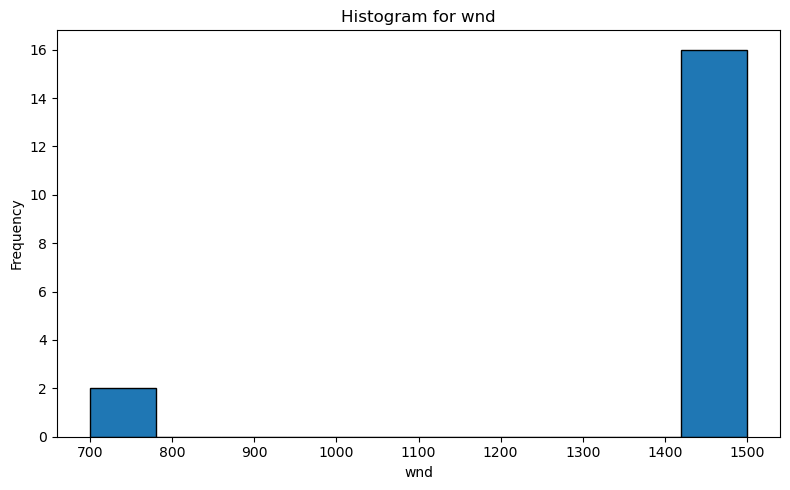

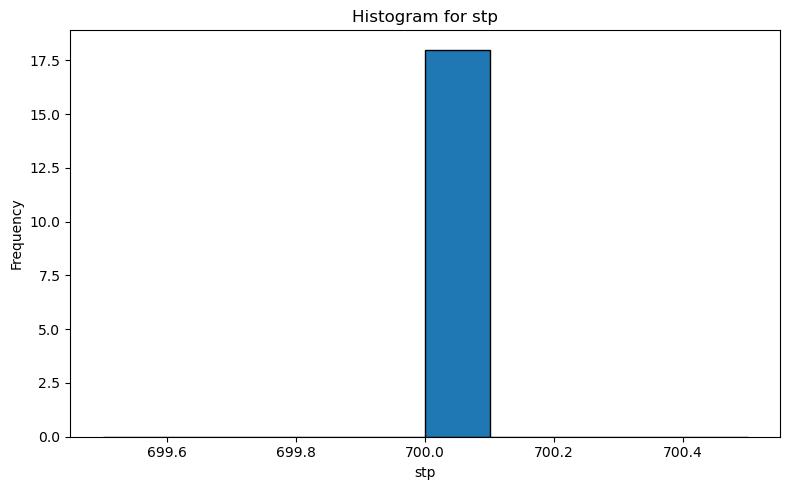

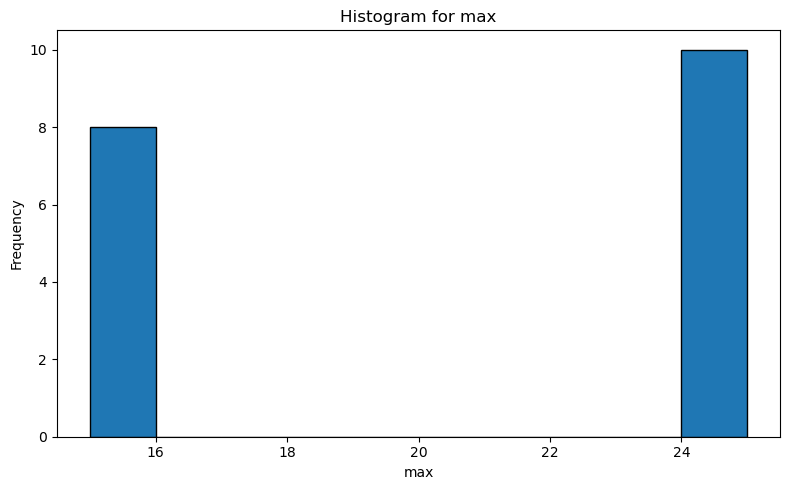

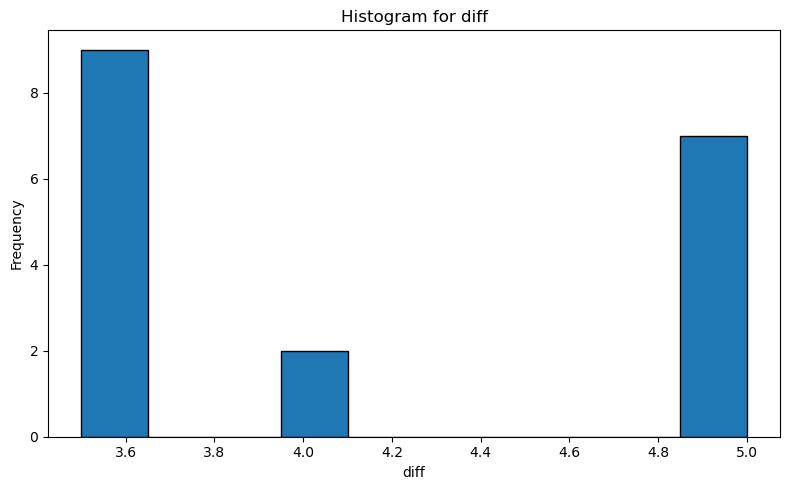

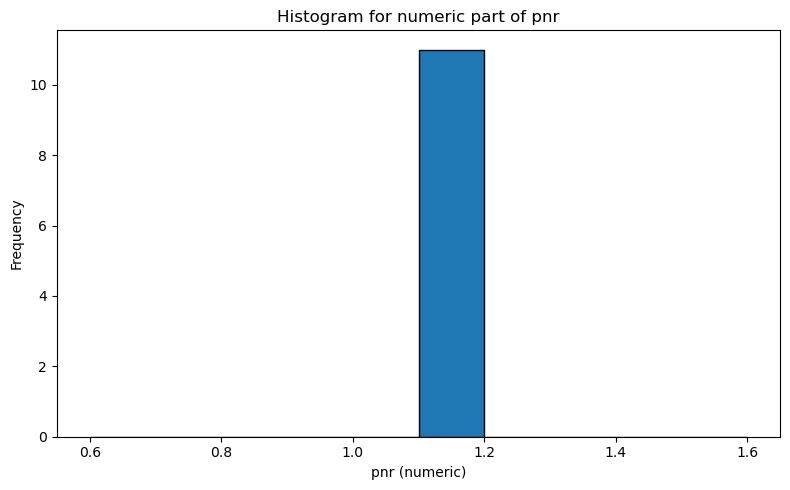

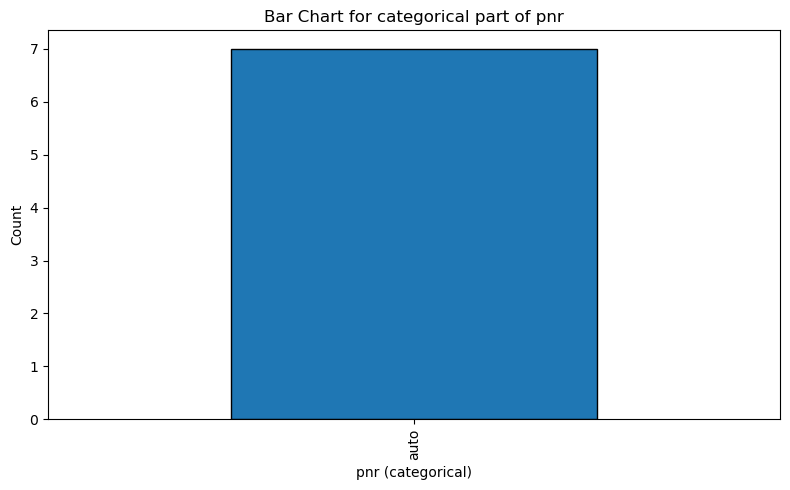

In [9]:
def parse_nc_file(nc_file):
    # This regex only matches the keys we expect.
    pattern = re.compile(r'(wnd|stp|max|diff|pnr)([\d\.a-zA-Z]+)')
    result = {}
    # Split the string by underscores.
    for token in nc_file.split('_'):
        match = pattern.match(token)
        if match:
            key, val = match.groups()
            try:
                # Attempt to convert to numeric if possible.
                if '.' in val:
                    result[key] = float(val)
                else:
                    result[key] = int(val)
            except ValueError:
                result[key] = val  # Keep as string if conversion fails.
    return result

# Parse the 'nc_file' column and create a DataFrame from the dictionaries.
parsed = df['nc_file'].apply(parse_nc_file)
parsed_df = pd.DataFrame(parsed.tolist())

print("\nParsed Parameters:")
print(parsed_df.head())

# Merge the parsed parameters back into the original DataFrame.
df = pd.concat([df, parsed_df], axis=1)
print("\nData with Parsed Parameter Columns:")
print(df.head())

# %% [code]
# Visualize each of the parameters.
# For keys other than "pnr", if all values are numeric, plot a histogram,
# otherwise plot a bar chart.
# For "pnr", we handle the mixture of numeric and categorical values separately.
keys = ['wnd', 'stp', 'max', 'diff', 'pnr']

for key in keys:
    if key != 'pnr':
        plt.figure(figsize=(8, 5))
        numeric_values = pd.to_numeric(df[key], errors='coerce')
        
        if numeric_values.isnull().sum() == 0:
            plt.hist(numeric_values, bins=10, edgecolor='black')
            plt.title(f"Histogram for {key}")
            plt.xlabel(key)
            plt.ylabel("Frequency")
        else:
            counts = df[key].value_counts()
            if not counts.empty:
                counts.plot(kind='bar', edgecolor='black')
                plt.title(f"Bar Chart for {key}")
                plt.xlabel(key)
                plt.ylabel("Count")
            else:
                print(f"No data to plot for key: {key}")
        plt.tight_layout()
        plt.show()
    else:
        # Special handling for "pnr" which can be numeric (like 1.1) or a categorical string (like "auto").
        pnr_numeric = pd.to_numeric(df[key], errors='coerce')
        
        # Plot numeric part if available.
        if pnr_numeric.notnull().sum() > 0:
            plt.figure(figsize=(8, 5))
            plt.hist(pnr_numeric.dropna(), bins=10, edgecolor='black')
            plt.title("Histogram for numeric part of pnr")
            plt.xlabel("pnr (numeric)")
            plt.ylabel("Frequency")
            plt.tight_layout()
            plt.show()
        else:
            print("No numeric pnr values found.")
        
        # Plot categorical part if available.
        pnr_cat = df[key][pnr_numeric.isnull()]
        if not pnr_cat.empty:
            counts = pnr_cat.value_counts()
            if not counts.empty:
                plt.figure(figsize=(8, 5))
                counts.plot(kind='bar', edgecolor='black')
                plt.title("Bar Chart for categorical part of pnr")
                plt.xlabel("pnr (categorical)")
                plt.ylabel("Count")
                plt.tight_layout()
                plt.show()
            else:
                print("No categorical pnr values to plot.")
        else:
            print("No categorical pnr values found.")

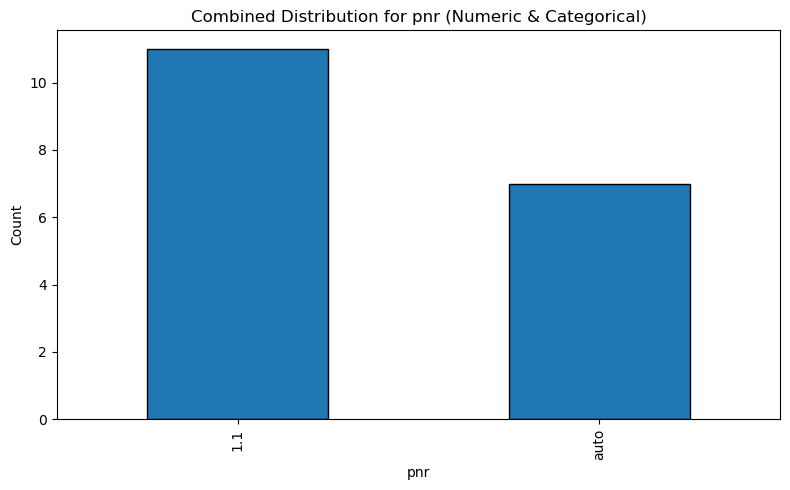

In [11]:
df['pnr_str'] = df['pnr'].astype(str)

# Count the occurrences of each unique pnr value.
pnr_counts = df['pnr_str'].value_counts()

# Sort the indices so that numeric values are sorted numerically, and non-numeric ones follow.
def pnr_sort_key(x):
    try:
        return (0, float(x))  # Numeric ones: sort by their numeric value.
    except ValueError:
        return (1, x)         # Non-numeric: sort lexicographically.

sorted_index = sorted(pnr_counts.index, key=pnr_sort_key)
sorted_counts = pnr_counts.loc[sorted_index]

# Plot the combined distribution.
plt.figure(figsize=(8, 5))
sorted_counts.plot(kind='bar', edgecolor='black')
plt.title("Combined Distribution for pnr (Numeric & Categorical)")
plt.xlabel("pnr")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [ ]:
# import os
# import sys
# import json
# import glob
# import pandas as pd
# import argparse

# # Add project root so that the functions can be imported
# sys.path.append(os.path.abspath('../..'))
# from utlis.sync_utlis.mini_dannce_sync import (
#     sync_videos,
#     align_miniscope_to_sixcam,
#     load_aligneddannce_and_process_ca_data,
#     load_aligneddannce_and_process_ca_data_custom
# )

# def get_rec_path_for_mini(raw_mini_path, mapping):
#     """
#     Given the raw mini_path and a mapping dictionary, return its corresponding rec_path.
#     """
#     if raw_mini_path not in mapping:
#         raise KeyError(f"Key '{raw_mini_path}' not found in mapping.")
#     return mapping[raw_mini_path].get("rec_path")

# def extract_mini_directory(raw_mini_path):
#     """
#     If raw mini_path ends with 'My_V4_Miniscope', remove that folder and return its parent directory (with trailing slash).
#     Otherwise, ensure the path ends with a slash.
#     """
#     norm_path = os.path.normpath(raw_mini_path)
#     if os.path.basename(norm_path) == "My_V4_Miniscope":
#         cleaned = os.path.dirname(norm_path)
#     else:
#         cleaned = norm_path
#     if not cleaned.endswith(os.sep):
#         cleaned += os.sep
#     return cleaned

# def extract_rec_directory(raw_rec_path):
#     """
#     Given a full rec_path (including a filename), return only its parent directory, ensuring a trailing slash.
#     """
#     parent_dir = os.path.dirname(os.path.dirname(os.path.dirname(raw_rec_path)))
#     if not parent_dir.endswith(os.sep):
#         parent_dir += os.sep
#     return parent_dir

# def extract_name_suffix(nc_file_path):
#     """
#     Given a full path to an .nc file, extract a suffix from the filename.
#     For example, if the file is named:
#       minian_dataset_wnd1000_stp700_max15_diff3.5_pnrauto.nc
#     then return: wnd1000_stp700_max15_diff3.5_pnrauto
#     If the filename does not follow the expected pattern, return an empty string.
#     """
#     nc_basename = os.path.basename(nc_file_path)
#     prefix = "minian_dataset_"
#     suffix = ".nc"
#     if nc_basename.startswith(prefix) and nc_basename.endswith(suffix):
#         return nc_basename[len(prefix):-len(suffix)]
#     return ""

# def process_good_minis(csv_path, json_path, nc_csv_path, dry_run=False):
#     """
#     Process minis using file locations specified by the caller.
    
#     Parameters:
#         csv_path (str): Path to the CSV file containing mini information.
#         json_path (str): Path to the JSON mapping file.
#         nc_csv_path (str): Path to the CSV mapping file for selecting .nc files.
#         dry_run (bool): If True, only print the discovered file paths without executing the heavy processing.
#     """
#     # Read original CSV and filter rows by condition.
#     df = pd.read_csv(csv_path)
#     df_filtered = df[df['condition'].isin(["good", "good_vein"])]
    
#     # Load the JSON mapping from mini_path to rec_path.
#     with open(json_path, 'r') as f:
#         mini_to_rec = json.load(f)
    
#     # Load the new CSV mapping to manually select .nc files, if available.
#     if os.path.exists(nc_csv_path):
#         nc_mapping_df = pd.read_csv(nc_csv_path)
#         nc_mapping_dict = dict(zip(nc_mapping_df["rec_path"], nc_mapping_df["nc_file"]))
#     else:
#         nc_mapping_dict = {}
    
#     # Process each filtered mini_path.
#     for idx, row in df_filtered.iterrows():
#         raw_mini_path = row["rec_path"]  # Use the raw value from the CSV.
#         try:
#             raw_rec_path = get_rec_path_for_mini(raw_mini_path, mini_to_rec)
#         except KeyError as e:
#             print(e)
#             continue

#         print("raw_rec_path:", raw_rec_path)
        
#         if raw_rec_path:
#             # Clean the paths for downstream processing.
#             mini_path = extract_mini_directory(raw_mini_path)
#             rec_path = extract_rec_directory(raw_rec_path)
            
#             print(f"Using matched rec_path: {rec_path} for mini_path: {mini_path}")
            
#             # Step: Find .nc files in the miniscope folder.
#             nc_folder = raw_mini_path
#             nc_files = glob.glob(os.path.join(nc_folder, "*.nc"))
#             selected_nc_file = None
            
#             if len(nc_files) == 0:
#                 print(f"No .nc files found in {nc_folder}.")
#             elif len(nc_files) == 1:
#                 selected_nc_file = nc_files[0]
#                 print(f"Found single .nc file: {selected_nc_file}")
#             else:
#                 # More than one .nc file exists: check if a specific file is set in the mapping.
#                 if raw_mini_path in nc_mapping_dict:
#                     selected_filename = nc_mapping_dict[raw_mini_path]
#                     potential_path = os.path.join(nc_folder, selected_filename)
#                     if os.path.exists(potential_path):
#                         selected_nc_file = potential_path
#                         print(f"Selected .nc file from mapping: {selected_nc_file}")
#                     else:
#                         print(f"Mapped .nc file '{selected_filename}' not found in {nc_folder}. Using first found file: {nc_files[0]}")
#                         selected_nc_file = nc_files[0]
#                 else:
#                     print(f"Multiple .nc files found in {nc_folder} but no mapping entry exists. Using first found file: {nc_files[0]}")
#                     selected_nc_file = nc_files[0]
            
#             # Extract parameter suffix from the .nc file name (if available).
#             name_suffix = ""
#             if selected_nc_file:
#                 name_suffix = extract_name_suffix(selected_nc_file)
#                 if name_suffix:
#                     print(f"Extracted name suffix: {name_suffix}")
#                 else:
#                     print("No name suffix extracted from the .nc filename.")
            
#             # Construct the expected alignment file paths.
#             dannce_file = os.path.join(rec_path, "DANNCE", "predict00", "save_data_AVG.mat")
#             mir_file = os.path.join(rec_path, "MIR_Aligned", "aligned_predictions_with_ca_and_dF_F.h5")
            
#             # If dry run is enabled, print the file names and skip further processing for this mini.
#             # if dry_run:
#             #     print("Dry run mode enabled. The following paths would be used:")
#             #     print(f"  mini_path: {mini_path}")
#             #     print(f"  rec_path: {rec_path}")
#             #     if selected_nc_file:
#             #         print(f"  Selected .nc file: {selected_nc_file}")
#             #         print(f"  Suffix to be appended: {name_suffix}")
#             #     else:
#             #         print("  No .nc file selected.")
#             #     print(f"  Expected DANNCE file: {dannce_file}")
#             #     print(f"  Expected MIR-Aligned file: {mir_file}")
#             #     print("-" * 50)
#             #     continue

#             # else:

#             # Check if alignment has already been completed.
#             if os.path.exists(dannce_file) and os.path.exists(mir_file):
#                 print(f"Alignment already completed for rec_path: {rec_path}. Skipping alignment process.")
#             else:
#                 print(0)
#                 # Step 1: Dannce alignment.
#                 # resultsss = sync_videos(
#                 #     rec_path,
#                 #     mini_path,
#                 #     start_frame=0,
#                 #     end_frame=200,
#                 #     threshold_mini=15,
#                 #     threshold_sixcam=3
#                 # )
                
#                 try:
#                     print(00)
#                     # align_miniscope_to_sixcam(resultsss, mini_path, rec_path)
#                 except (TypeError, IndexError) as e:
#                     print(f"Error during align_miniscope_to_sixcam for mini_path: {mini_path}. Skipping this mini. Error: {e}")
#                     continue
            
#             # Step 2: Load alignment and process calcium data.
#             if selected_nc_file:
#                 # df_merged_with_dF_F = load_aligneddannce_and_process_ca_data_custom(
#                 #     rec_path,
#                 #     mini_path,
#                 #     nc_file=selected_nc_file,
#                 #     # name_suffix=name_suffix
#                 # )
#                 print(1)
#             else:
#                 # df_merged_with_dF_F = load_aligneddannce_and_process_ca_data(rec_path, mini_path)
#                 print(2)
                
#                 # (Optional) Further processing on df_merged_with_dF_F can be done here.
#         else:
#                 print(f"No matching rec_path found for mini_path: {raw_mini_path}")

# # if __name__ == "__main__":
#     # parser = argparse.ArgumentParser(description="Process good minis with optional dry run mode and custom file locations.")
#     # parser.add_argument("--csv-path", type=str,
#     #                     default="/home/lq53/mir_repos/BBOP/random_tests/25feb_more_corr_explo/mini_sanity.csv",
#     #                     help="Path to the CSV file with mini data.")
#     # parser.add_argument("--json-path", type=str,
#     #                     default="/home/lq53/mir_repos/BBOP/random_tests/25feb_more_corr_explo/mini_to_rec_mapping.json",
#     #                     help="Path to the JSON mapping file.")
#     # parser.add_argument("--nc-csv-path", type=str,
#     #                     default="/home/lq53/mir_repos/BBOP/random_tests/25feb_more_corr_explo/mini_nc_mapping.csv",
#     #                     help="Path to the CSV file mapping mini rec paths to .nc files.")
#     # parser.add_argument("--dry-run", action="store_true",
#     #                     help="Enable dry run mode (print file names without processing).")
#     # # Use parse_known_args to ignore extra Jupyter arguments.
#     # args, unknown = parser.parse_known_args()
    
#     # process_good_minis(csv_path=args.csv_path,
#     #                    json_path=args.json_path,
#     #                    nc_csv_path=args.nc_csv_path,
#     #                    dry_run=args.dry_run)
# process_good_minis(csv_path="/home/lq53/mir_repos/BBOP/random_tests/25feb_more_corr_explo/mini_sanity.csv",
#                    json_path="/home/lq53/mir_repos/BBOP/random_tests/25feb_more_corr_explo/mini_to_rec_mapping.json",
#                    nc_csv_path="/home/lq53/mir_repos/BBOP/random_tests/25feb_more_corr_explo/mini_nc_mapping.csv")
